In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install uv
!pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.6/708.6 kB 46.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Lambda
from tensorflow.keras.models import Sequential
import tensorflow as tf
import cv2
import os
from sklearn.metrics.pairwise import cosine_similarity
import gdown
import trimesh
import zipfile

Importar libs

Extração dos dados

In [8]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)

    # Calcular altura da imagem original em 60% da parte superior
    img_height = int(img.shape[0] * 0.60)
    img = img[:img_height, :]

    # Converter para escala de cinza
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize para 224x224
    img = cv2.resize(img, (224, 224))

    # 3 canais para manter compatibilidade com MobileNetV2
    # img = np.stack((img,)*3, axis=-1)

    # Normalizar para [0,1]
    img = img / 255.0

    return img

Preparar dados de treinamento

In [9]:
# Baixar os dados de treino
output_path = '/content/kitti_dataset.zip'
url = f'https://drive.google.com/uc?id=1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT'

gdown.download(url, output_path, quiet=False)

extract_dir = output_path.replace(".zip", "")
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Ajuste aqui: usar a pasta "post-processed" dentro do diretório extraído
post_processed_dir = os.path.join(extract_dir, "post-processed")

# Verificar se a pasta existe
if not os.path.exists(post_processed_dir):
    print(f"Pasta 'post-processed' não encontrada em {extract_dir}")
    print(f"Conteúdo do diretório: {os.listdir(extract_dir)}")
else:
    # Agora usamos as subpastas dentro de post-processed
    folders = sorted(os.listdir(post_processed_dir))

    original_img_dataset = pd.DataFrame(columns=['img', 'id'])
    img_dataset = pd.DataFrame(columns=['img', 'id'])

    for idx, folder in enumerate(folders):
        folder_path = os.path.join(post_processed_dir, folder)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith('.jpg'):
                    img_path = os.path.join(folder_path, filename)
                    img_original = cv2.imread(img_path)
                    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
                    try:
                        # Separar os ids por pessoa

                        # Dataset de imagens originais, com as imagens em RGB que não foram processadas e não são utilizadas para o treinamento
                        original_img_dataset = pd.concat([original_img_dataset, pd.DataFrame({'img': [img_original], 'id': [idx]})], ignore_index=True)

                        # Dataset de imagens processadas, com as imagens em escala de cinza que são utilizadas para o treinamento
                        img = preprocess_image(img_path)
                        img_dataset = pd.concat([img_dataset, pd.DataFrame({'img': [img], 'id': [idx]})], ignore_index=True)
                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

    print('len data', len(img_dataset))

Downloading...
From (original): https://drive.google.com/uc?id=1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT
From (redirected): https://drive.google.com/uc?id=1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT&confirm=t&uuid=a580521e-9ee3-4ab0-a6a5-e9994029a2db
To: /content/kitti_dataset.zip
100%|██████████| 71.4M/71.4M [00:00<00:00, 241MB/s]


len data 12000


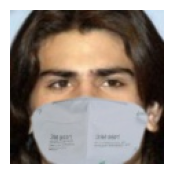

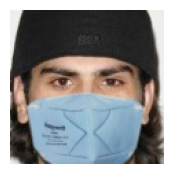

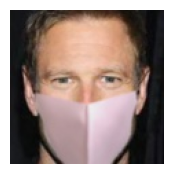

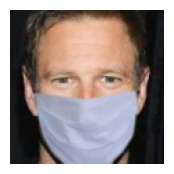

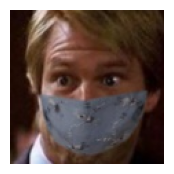

In [10]:
# print first 5 images

for i in range(5):
    plt.figure(figsize=(2, 2))
    plt.imshow(original_img_dataset['img'][i])
    plt.axis('off')
    plt.show()

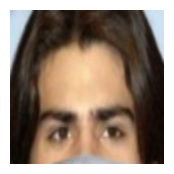

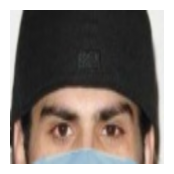

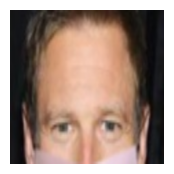

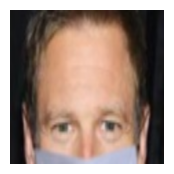

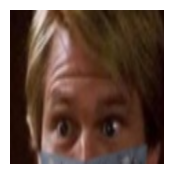

In [11]:
# print first 5 images

for i in range(5):
    plt.figure(figsize=(2, 2))
    plt.imshow(img_dataset['img'][i])
    plt.axis('off')
    plt.show()

In [ ]:
X = np.stack(img_dataset['img'].values)
y = img_dataset['id'].values

Configurar modelo

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Construir o modelo sequencial completo
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(128),
    Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))
])

### Âncora
- É a imagem de referência (ex: uma foto da pessoa A)
- Serve como ponto de comparação para as outras duas imagens

### Positivo
- É outra imagem da **mesma pessoa** da âncora (outra foto da pessoa A)
- Pode ter diferenças como ângulo, iluminação, expressão facial, uso de máscara

### Negativo
- É uma imagem de uma **pessoa diferente** (foto da pessoa B)
- Representa o que o modelo deve aprender a distinguir da âncora

In [ ]:
# A classe TripletGenerator é um gerador de dados para o treinamento do modelo
class TripletGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=32, num_triplets=5000, **kwargs):
        super().__init__(**kwargs)
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_triplets = num_triplets

        # Encontrar classes com pelo menos 2 amostras
        unique_labels, counts = np.unique(labels, return_counts=True)
        self.classes = unique_labels[counts >= 2]

        if len(self.classes) == 0:
            raise ValueError("Não há classes com pelo menos 2 amostras. Impossível criar triplets.")

        self.indexes = np.arange(num_triplets)


    def __len__(self):
        return int(np.ceil(self.num_triplets / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_triplets = []

        for _ in range(len(batch_indexes)):
            # Escolher classe âncora aleatoriamente (apenas entre classes com múltiplas amostras)
            anchor_class = np.random.choice(self.classes)

            # Índices de imagens da mesma classe (positivos)
            positive_indices = np.where(self.labels == anchor_class)[0]

            # Verificar se ainda temos pelo menos 2 imagens nesta classe
            if len(positive_indices) < 2:
                continue

            # Escolher âncora e positivo aleatoriamente da mesma classe
            anchor_idx = np.random.choice(positive_indices)
            positive_candidates = positive_indices[positive_indices != anchor_idx]

            # Verificação extra para garantir que temos positivos após remover o âncora
            if len(positive_candidates) == 0:
                continue

            positive_idx = np.random.choice(positive_candidates)

            # Escolher negativo de outra classe
            negative_classes = self.classes[self.classes != anchor_class]
            # Verificar se temos outras classes disponíveis
            if len(negative_classes) == 0:
                continue

            negative_class = np.random.choice(negative_classes)
            negative_indices = np.where(self.labels == negative_class)[0]
            negative_idx = np.random.choice(negative_indices)

            batch_triplets.append([
                self.images[anchor_idx],
                self.images[positive_idx],
                self.images[negative_idx]
            ])

        # Garantir que temos pelo menos um triplet no batch
        if not batch_triplets:
            # Tenta novamente com outro índice
            return self.__getitem__((idx + 1) % len(self))

        batch_triplets = np.array(batch_triplets)
        triplets_flat = batch_triplets.reshape(-1, 224, 224, 3)
        targets = np.zeros(len(batch_triplets) * 3)

        return triplets_flat, targets

In [ ]:
# A loss function triplet_loss calcula a perda triplet, que é uma função que mede a distância entre âncoras, positivos e negativos
# A ideia é minimizar a distância entre âncoras e positivos, enquanto maximiza a distância entre âncoras e negativos
def triplet_loss(y_true, y_pred, alpha=0.2):
	total = tf.shape(y_pred)[0]
	third = total // 3

	anchor = y_pred[0:third]
	positive = y_pred[third:2*third]
	negative = y_pred[2*third:total]

	# Calcular distâncias entre âncora, positivo e negativo
	pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
	neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)

	# Triplet Loss
	basic_loss = pos_dist - neg_dist + alpha
	loss = tf.maximum(basic_loss, 0.0)
	return tf.reduce_mean(loss)

Compilar e treinar o modelo

In [ ]:
# Compilar o modelo com a função de perda triplet loss
model.compile(optimizer='adam', loss=triplet_loss)

# Cria o gerador de triplets
triplet_gen = TripletGenerator(X, y, batch_size=32, num_triplets=5000)

# Treina o modelo com o gerador
history = model.fit(
    triplet_gen,
    epochs=10,
    steps_per_epoch=len(triplet_gen),
    verbose=1
)

Criar banco de dados com vetores descritores

In [ ]:
# Função para extrair vetores descritores
def extract_features(model, images):
    features = model.predict(images)
    return features

In [ ]:
# Extrair características de todas as imagens do dataset
celebrity_features = extract_features(model, X)

# Criar banco de dados de características
feature_database = {
    'features': celebrity_features,
    'labels': y
}

# # Podemos também salvar para uso futuro
# np.save('feature_database.npy', feature_database)

Adicionar nova pessoa ao banco

In [ ]:
# Carregar a imagem da nova pessoa
new_person_path = "face-test\marcelinho_no_db.jpg"  # Supondo que você já baixou a imagem
new_person_img = preprocess_image(new_person_path)
new_person_img_array = np.expand_dims(new_person_img, axis=0)

# Extrair características
new_person_features = extract_features(model, new_person_img_array)

# Atribuir um novo ID para esta pessoa (após o último ID existente)
new_person_id = np.max(y) + 1

# Adicionar ao banco de dados
img_original = cv2.imread(new_person_path)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
original_img_dataset = pd.concat([original_img_dataset, pd.DataFrame({'img': [img_original], 'id': [new_person_id]})], ignore_index=True)
feature_database['features'] = np.vstack([feature_database['features'], new_person_features])
feature_database['labels'] = np.append(feature_database['labels'], new_person_id)

print(f"Nova pessoa adicionada ao banco de dados com ID {new_person_id}")

Teste final

In [ ]:
test_image_path = "face-test\marcelinho_na_inferencia.jpg"

# Adicionar ao banco de dados com imagens originais
img_original = cv2.imread(test_image_path)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
original_img_dataset = pd.concat([original_img_dataset, pd.DataFrame({'img': [img_original], 'id': [new_person_id]})], ignore_index=True)

plt.figure(figsize=(6, 6))
plt.imshow(img_original)
plt.title("Imagem original de pessoa a ser buscada")
plt.axis('off')
plt.show()

# Imagem não é adicionada ao banco de dados, apenas pré-processada e utilizada na inferência
test_image = preprocess_image(test_image_path)
test_image_array = np.expand_dims(test_image, axis=0)

# Exibir a imagem a ser buscada
plt.figure(figsize=(6, 6))
plt.imshow(test_image)
plt.title("Imagem processada de pessoa a ser buscada")
plt.axis('off')
plt.show()

In [ ]:
# Extrair características da imagem a ser buscada
test_features = extract_features(model, test_image_array)

# Calcular similaridade com todas as faces no banco de dados
# Usamos similaridade de cosseno como métrica que compara a distância entre vetores em um espaço vetorial
# A similaridade de cosseno é uma medida de similaridade entre dois vetores que mede o ângulo entre eles
similarities = cosine_similarity(test_features, feature_database['features'])[0]

# Encontrar a correspondência mais próxima
best_match_idx = np.argmax(similarities)
best_match_id = feature_database['labels'][best_match_idx]
best_match_score = similarities[best_match_idx]

found_img = original_img_dataset['img'][original_img_dataset['id'] == best_match_id].values[0]

# Exibir o resultado da busca com a imagem da pessoa correspondente
print(f"Score de similaridade: {best_match_score:.4f}")
plt.figure(figsize=(6, 6))
plt.imshow(found_img)
plt.title(f"Pessoa encontrada: ID {best_match_id}")
plt.axis('off')
plt.show()

In [ ]:
def find_top_matches(test_image_array, model, feature_database, original_img_dataset, top_n=5, specific_id=None):
    # Extrair características da imagem a ser buscada
    test_features = extract_features(model, test_image_array)

    # Sempre calcular o ranking completo para poder exibir a posição global
    full_similarities = cosine_similarity(test_features, feature_database['features'])[0]
    full_ranking = np.argsort(full_similarities)[::-1]

    # Mapeamento do índice para a posição no ranking (para otimização)
    idx_to_rank = {idx: rank+1 for rank, idx in enumerate(full_ranking)}

    if specific_id is not None:
        # Filtrar apenas as características do ID específico
        mask = np.array(feature_database['labels']) == specific_id
        if not np.any(mask):
            print(f"ID {specific_id} não encontrado no banco de dados!")
            return None

        # Índices no conjunto original onde o ID é o específico
        id_indices = np.where(mask)[0]

        # Posições destes índices no ranking geral
        positions_in_ranking = [idx_to_rank[idx] for idx in id_indices]

        # Obter características apenas deste ID
        filtered_features = feature_database['features'][mask]
        similarities = cosine_similarity(test_features, filtered_features)[0]

        # Ordenar por similaridade dentro deste ID específico
        top_indices_within_id = np.argsort(similarities)[::-1][:top_n]
        top_scores = similarities[top_indices_within_id]
        top_ids = [specific_id] * len(top_indices_within_id)

        # Ajustar os índices para o banco de dados original
        original_indices = id_indices[top_indices_within_id]

        # Obter as posições globais para estes índices
        positions = [positions_in_ranking[i] for i in top_indices_within_id]
    else:
        # Usar o ranking completo já calculado
        top_indices = full_ranking[:top_n]
        top_scores = full_similarities[top_indices]
        top_ids = [feature_database['labels'][idx] for idx in top_indices]
        original_indices = top_indices
        positions = list(range(1, len(top_indices) + 1))  # Já estão em ordem 1, 2, 3, ...

    # Determinar quantas correspondências podemos realmente mostrar
    available_matches = len(original_indices)

    # Calcular layout de grade apropriado para visualização
    if available_matches <= 3:
        rows, cols = 1, available_matches
    else:
        cols = min(5, available_matches)  # No máximo 5 colunas
        rows = (available_matches + cols - 1) // cols  # Arredonda para cima

    # Exibir as correspondências encontradas
    if available_matches > 0:
        plt.figure(figsize=(cols*3, rows*3))

        for i, (idx, score, person_id, pos) in enumerate(zip(original_indices, top_scores, top_ids, positions)):
            # Obter a imagem correspondente
            matching_imgs = original_img_dataset[original_img_dataset['id'] == person_id]
            if len(matching_imgs) > 0:
                found_img = matching_imgs['img'].values[0]

                # Criar subplot para cada correspondência
                plt.subplot(rows, cols, i+1)
                plt.imshow(found_img)
                title = f"ID: {person_id}\nScore: {score:.4f}\nRank Global: {pos}"
                plt.title(title)
                plt.axis('off')

        title = f"Top {available_matches} correspondências"
        if specific_id is not None:
            title += f" para ID {specific_id}"

        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Ajusta espaço para o título principal
        plt.show()

        # Exibir também informações em formato de texto
        print(f"{title}:")
        for i, (score, person_id, pos) in enumerate(zip(top_scores, top_ids, positions)):
            print(f"{i+1}. ID {person_id}: Score={score:.4f}, Ranking Global={pos}")

    return {
        'indices': original_indices,
        'scores': top_scores,
        'ids': top_ids,
        'positions': positions
    }


In [ ]:
# Para ver as 100 melhores correspondências no banco de dados
find_top_matches(test_image_array, model, feature_database, original_img_dataset, top_n=100)

# Para ver onde o ID 2996 está ranqueado entre todas as imagens
find_top_matches(test_image_array, model, feature_database, original_img_dataset, top_n=1, specific_id=2996)
